In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
import csv
from pickle import dump
from keras.utils.vis_utils import plot_model
from pickle import load

random.seed(2)
random_state = 2

C:\Users\MacGy\AppData\Local\Temp\ipykernel_21572\1888795266.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [4]:
#WORKING DIRECTORY
path = Path.cwd()
save_path = Path(path / 'Ann_model_MLT_real')
load_path = Path(path / 'Ann_model_MLT')

parent_path =  path.parent

#DATA LOADING
data = pd.read_excel(parent_path / 'dataset\Real_Dataset2.xlsx', header=0)

print(data)
data.isnull().sum()
#variables to consider
feat = ['Influent Flow',
'Influent pH',
'Biofor DN Temperature',
'Biofor CN - Dissolved oxygen',
'Effluent Flow',
'Effluent pH']
 
#targets = list(data.columns[-3:])
targets = ['Effluent COD','Effluent Total suspended solids']
 
data1 = data.loc[462:]
X = data[feat]
y = data[targets]
data.isnull().sum()
print(X)

                    Date  Influent Flow  Influent pH     TMEDIA   
0    2021-12-23 10:00:00    2544.914865     6.892293  17.001293  \
1    2021-12-23 11:00:00    2562.337067     6.896180  16.770126   
2    2021-12-23 12:00:00    2608.118364     6.906006  16.768217   
3    2021-12-23 13:00:00    2492.566272     6.919798  16.840346   
4    2021-12-23 14:00:00    2406.911901     6.937250  16.354207   
...                  ...            ...          ...        ...   
2334 2022-03-31 05:00:00    2382.340405     8.168114  17.616545   
2335 2022-03-31 06:00:00    2426.835215     8.163622  17.716646   
2336 2022-03-31 07:00:00    2353.709824     8.149370  17.644735   
2337 2022-03-31 08:00:00    2413.925518     8.145649  18.062907   
2338 2022-03-31 09:00:00    2420.341770     8.103961  18.222254   

      Biofor CN - Dissolved oxygen  Effluent Flow  Effluent pH  NNOx_OUT_P   
0                         8.557711    2544.914865     6.820682    8.297333  \
1                         8.508642    2

In [5]:
#PARAMETERS TO SET
 
Loss= {"COD": 'mean_squared_error',
       "TSS": 'mean_squared_error'}#,
       #"TSS": 'mean_squared_error'}
 
lr=0.01
 
Optimizer= Adam(learning_rate=lr)
#Optimizer= SGD(learning_rate=lr)

 
epochs=1000
#bs=128
bs=128

In [6]:
#DEFINE NETWORK ARCHITECTURE FUNCTION
clear_session()
NeuNet = tf.keras.models.load_model(load_path)
#DEFINE NETWORK ARCHITECTURE FUNCTION
def ANN_AP(X,T,Loss,Optimizer):
    
    x = Input(shape=(X.shape[1], ))
    shared1 = Dense(256, activation='relu')(x)
    shared2 = Dense(256, activation='relu')(shared1)
    sub1 = Dense(128, activation='relu')(shared2)
    sub2 = Dense(128, activation='relu')(shared2)
    sub1 = Dense(64, activation='relu')(sub1)
    sub2 = Dense(64, activation='relu')(sub2)
    sub1 = Dense(32, activation='relu')(sub1)
    sub2 = Dense(32, activation='relu')(sub2)
    sub1 = Dense(16, activation='relu')(sub1)
    sub2 = Dense(16, activation='relu')(sub2)
    sub1 = Dense(8, activation='relu')(sub1)
    sub2 = Dense(8, activation='relu')(sub2)
    out1 = Dense(1, name="COD", activation='linear')(sub1)
    out2 = Dense(1, name="TSS", activation='linear')(sub2)

    model = Model(inputs=x, outputs=[out1, out2])

    model.summary()
    
    model.compile(loss=Loss, optimizer=Optimizer, metrics=['MeanSquaredError','MeanAbsoluteError'])

    return model
#NeuNet = ANN_AP(X,y,Loss,Optimizer)


In [7]:
#SPLIT AND SCALE DATA
x_tv, x_test, y_tv, y_test = train_test_split(X, y, test_size=0.5, shuffle= True, random_state = random_state)
x_train, x_valid, y_train, y_valid = train_test_split(x_tv, y_tv, test_size=0.20, shuffle= True, random_state = random_state)
print(x_train.shape, x_valid.shape, x_test.shape)

# Transform
ss = StandardScaler()
ss.fit(x_train)

x_train_scaled = ss.transform(x_train)
x_valid_scaled = ss.transform(x_valid)
x_test_scaled  = ss.transform(x_test)

# save the scaler
#dump(ss, open(save_path / 'scaler_MLT.pkl', 'wb'))

(935, 6) (234, 6) (1170, 6)


In [8]:
#CALL AND TRAIN NETWORK
 
es = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
history = NeuNet.fit(x_train_scaled, y={"COD": y_train.iloc[:,0],"TSS": y_train.iloc[:,1]},#,"TSS": y_train.iloc[:,2]}, 
                     validation_data = (x_valid_scaled,{"COD": y_valid.iloc[:,0],"TSS": y_valid.iloc[:,1]}),#,"TSS": y_valid.iloc[:,2]}), 
                     epochs=20, batch_size=bs, verbose=1, callbacks=[es])
 
#Save trained model
NeuNet.save(save_path)

Epoch 1/20
8/8 [==============================] - 2s 42ms/step - loss: 299.5828 - COD_loss: 288.2151 - TSS_loss: 11.3676 - COD_mean_squared_error: 288.2151 - COD_mean_absolute_error: 9.0207 - TSS_mean_squared_error: 11.3676 - TSS_mean_absolute_error: 2.6418 - val_loss: 69.1617 - val_COD_loss: 60.2044 - val_TSS_loss: 8.9572 - val_COD_mean_squared_error: 60.2044 - val_COD_mean_absolute_error: 5.1073 - val_TSS_mean_squared_error: 8.9572 - val_TSS_mean_absolute_error: 2.2181
Epoch 2/20
8/8 [==============================] - 0s 7ms/step - loss: 50.1307 - COD_loss: 40.2396 - TSS_loss: 9.8911 - COD_mean_squared_error: 40.2396 - COD_mean_absolute_error: 4.2445 - TSS_mean_squared_error: 9.8911 - TSS_mean_absolute_error: 2.3007 - val_loss: 29.5481 - val_COD_loss: 21.0538 - val_TSS_loss: 8.4943 - val_COD_mean_squared_error: 21.0538 - val_COD_mean_absolute_error: 3.4517 - val_TSS_mean_squared_error: 8.4943 - val_TSS_mean_absolute_error: 2.1010
Epoch 3/20
8/8 [==============================] - 0s 7

INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_MLT_real\assets


INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_MLT_real\assets


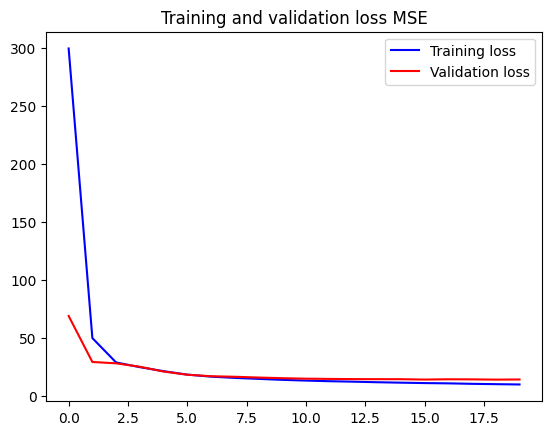

In [9]:
#PLOT TRAINING CURVES
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss MSE')
plt.legend()


In [10]:
#If we want to reload a trainend model
#NeuNet = tf.keras.models.load_model(save_path)

In [11]:
plot_model(NeuNet, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
#Export metrics on CSV

with open(save_path / 'Metrics.csv', "w") as f:
  fieldnames = ['Variable','CC','RMSE','SI','BIAS','MeanAPD','StdAPD']
  writer = csv.DictWriter(f, fieldnames=fieldnames)
  writer.writeheader()

In [13]:
from tensorflow.keras.callbacks import Callback
import time
class PredictionCallback(Callback):
    start_time = time.time()
    
    def on_predict_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting prediction ...")
    
    def on_predict_end(self, logs=None):
        end_time = time.time()-self.start_time
        print(f"Inference time: {end_time} seconds")

Starting prediction ...
37/37 [==============================] - 0s 2ms/step

    ----------------------------------------
    # Variable: Effluent COD
    # CC: PearsonRResult(statistic=0.30884683036826216, pvalue=2.8144820767225816e-27)
    # RMSE: 2.7735107880153977
    # SI: 0.20987721044466295
    # BIAS: 0.023314379289415176
    # MeanAPD: 16.675274327346433
    # StdAPD: 13.438589403536023
    
    ----------------------------------------
    

    ----------------------------------------
    # Variable: Effluent Total suspended solids
    # CC: PearsonRResult(statistic=0.5782733979544931, pvalue=2.3003023265570637e-105)
    # RMSE: 2.5778464208989007
    # SI: 0.4761166402034785
    # BIAS: 0.07932343602679096
    # MeanAPD: 40.18417280815326
    # StdAPD: 38.90121364838948
    
    ----------------------------------------
    


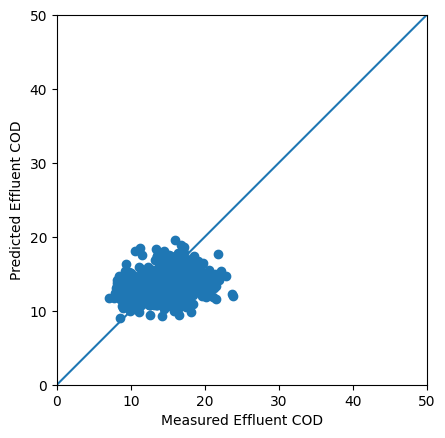

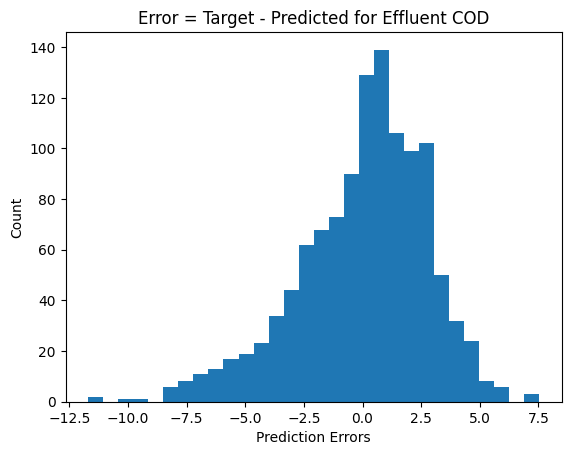

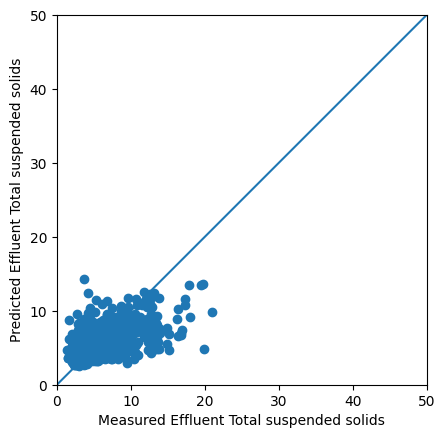

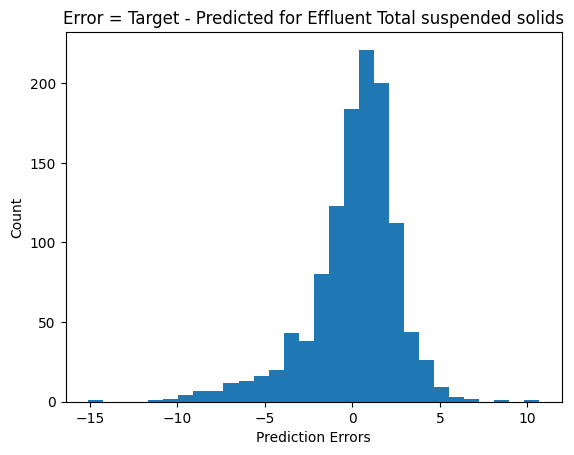

In [14]:
#INFERENCE ON TEST SET

# make predictions on the testing data
preds = NeuNet.predict(x_test_scaled,callbacks=PredictionCallback())

for i in range(0,len(targets)):
    
    name = targets[i]
    
    pred = preds[i].flatten()
    y_test_var = y_test.iloc[:,i]
    
    diff = pred - y_test_var
    percentDiff = (diff / y_test_var) * 100
    
    #METRICS
    AbsPercentDiff = np.abs(percentDiff)
    MeanAPD = np.mean(AbsPercentDiff)
    StdAPD = np.std(AbsPercentDiff)
    
    CCTest  = pearsonr(y_test_var,pred)   #it should be the same thing of MATLAB 'corr' 
    RmseTest  = sqrt(mean_squared_error(y_test_var,pred))
    SITest  = sqrt(mean_squared_error(y_test_var,pred))/np.mean(y_test_var)
    BiasTest  = np.sum(pred-y_test_var)/y_test_var.shape[0]

    s = f"""
    {'-'*40}
    # Variable: {name}
    # CC: {CCTest}
    # RMSE: {RmseTest}
    # SI: {SITest}
    # BIAS: {BiasTest}
    # MeanAPD: {MeanAPD}
    # StdAPD: {StdAPD}
    
    {'-'*40}
    """
    
    print(s)
    
    #Export metrics on CSV
    
    with open(save_path / 'Metrics.csv', "a") as f:
      writer = csv.DictWriter(f, fieldnames=fieldnames)
      writer.writerow({'Variable':name,'CC':CCTest,'RMSE':RmseTest,'SI':SITest,
                       'BIAS':BiasTest,'MeanAPD':MeanAPD,'StdAPD':StdAPD})
    plt.figure()
    a = plt.axes(aspect='equal')
    plt.scatter(y_test_var, pred)
    plt.xlabel('Measured '+name)
    plt.ylabel('Predicted '+name)
    lims = [0, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    plt.figure()
    plt.hist(diff, bins=30)
    plt.title('Error = Target - Predicted for '+name)
    plt.xlabel('Prediction Errors')
    _ = plt.ylabel('Count')